In [1]:
!pip install -q tensorflow-addons


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import zipfile
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 22.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
ydata-profiling 4.12.2 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.17.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

ModuleNotFoundError: No module named 'keras.src.engine'

In [2]:
import tensorflow_datasets as tfds

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'patch_camelyon',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/32768 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.1K4K53_2.0.0/patch_camelyon-test.tfrecord*...:  …

Generating train examples...:   0%|          | 0/262144 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.1K4K53_2.0.0/patch_camelyon-train.tfrecord*...: …

Generating validation examples...:   0%|          | 0/32768 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/patch_camelyon/incomplete.1K4K53_2.0.0/patch_camelyon-validation.tfrecord*…

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [3]:
print("Dataset loaded:")
print(f"Training samples: {ds_info.splits['train'].num_examples}")
print(f"Validation samples: {ds_info.splits['validation'].num_examples}")
print(f"Test samples: {ds_info.splits['test'].num_examples}")

Dataset loaded:
Training samples: 262144
Validation samples: 32768
Test samples: 32768


In [4]:

IMG_SIZE = 128
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label



ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


IMG_SIZE = 128
PATCH_SIZE = 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
BATCH_SIZE = 32
EPOCHS = 20
PROJECTION_DIM = 64

NUM_HEADS = 4
TRANSFORMER_UNITS = [128, 64]
TRANSFORMER_LAYERS = 4
MLP_HEAD_UNITS = [128, 64]


In [6]:
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.pos_embedding(positions)
        return encoded


In [7]:
def build_vit_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    
    patches = PatchExtractor(patch_size=PATCH_SIZE)(inputs)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)


    for _ in range(TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=PROJECTION_DIM)(x1, x1)
        x2 = layers.Add()([attention, encoded_patches])

        
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        mlp = keras.Sequential([
            layers.Dense(TRANSFORMER_UNITS[0], activation=tf.nn.gelu),
            layers.Dense(TRANSFORMER_UNITS[1])
        ])
        x4 = mlp(x3)
        encoded_patches = layers.Add()([x4, x2])


    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    features = layers.Dense(MLP_HEAD_UNITS[0], activation=tf.nn.gelu)(representation)
    features = layers.Dropout(0.3)(features)
    logits = layers.Dense(1, activation="sigmoid")(features)

    return keras.Model(inputs=inputs, outputs=logits)


In [8]:
vit_model = build_vit_model()
vit_model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
vit_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_extractor           │ (None, None, 768)      │              0 │ input_layer[0][0]      │
│ (PatchExtractor)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 64, 64)         │         53,312 │ patch_extractor[0][0]  │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 64)         │            128 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 64, 64)         │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64)         │              0 │ multi_head_attention[… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 64, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64, 64)         │         16,576 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64)         │              0 │ sequential[0][0],      │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 64, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 64, 64)         │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 64, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64)         │         16,576 │ layer_normalization_3… │
├──────────────────────

 Total params: 910,785 (3.47 MB)

 Trainable params: 910,785 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "vit.keras", save_best_only=True, monitor="val_accuracy", mode="max"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)


history = vit_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=12,
    
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)


Epoch 1/12
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 126s 16ms/step - accuracy: 0.7344 - loss: 0.5205 - val_accuracy: 0.8471 - val_loss: 0.3472 - learning_rate: 1.0000e-04
Epoch 2/12
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 94s 14ms/step - accuracy: 0.8440 - loss: 0.3609 - val_accuracy: 0.8559 - val_loss: 0.3263 - learning_rate: 1.0000e-04
Epoch 3/12
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 94s 14ms/step - accuracy: 0.8609 - loss: 0.3281 - val_accuracy: 0.8634 - val_loss: 0.3114 - learning_rate: 1.0000e-04
Epoch 4/12
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 94s 14ms/step - accuracy: 0.8714 - loss: 0.3030 - val_accuracy: 0.8676 - val_loss: 0.3025 - learning_rate: 1.0000e-04
Epoch 5/12
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - accuracy: 0.8825 - loss: 0.2818 - val_accuracy: 0.8719 - val_loss: 0.2938 - learning_rate: 1.0000e-04
Epoch 6/12
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 94s 14ms/step - accuracy: 0.8910 - loss: 0.2646 - val_accuracy: 0.8911 - val_loss: 0.2628 - learning_rate: 1.0000e-04
Epoch 7/12
6554/6554 ━━━━━━━━━━━━━━━━━━

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class PatchExtractor(Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtractor, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super(PatchExtractor, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config


In [34]:
@register_keras_serializable()
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection.units
        })
        return config

In [35]:
model = tf.keras.models.load_model(
    '/kaggle/working/vit_model.h5',
    custom_objects={
        'PatchExtractor': PatchExtractor,
        'PatchEncoder': PatchEncoder
    }
)
print("Model loaded successfully!")


Model loaded successfully!


In [36]:
vit_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_extractor           │ (None, None, 768)      │              0 │ input_layer[0][0]      │
│ (PatchExtractor)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder             │ (None, 64, 64)         │         53,312 │ patch_extractor[0][0]  │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 64)         │            128 │ patch_encoder[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 64, 64)         │         66,368 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64)         │              0 │ multi_head_attention[… │
│                           │                        │                │ patch_encoder[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 64, 64)         │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 64, 64)         │         16,576 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 64, 64)         │              0 │ sequential[0][0],      │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 64, 64)         │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 64, 64)         │         66,368 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 64, 64)         │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 64, 64)         │            128 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 64, 64)         │         16,576 │ layer_normalization_3… │
├──────────────────────

 Total params: 2,732,357 (10.42 MB)

 Trainable params: 910,785 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,821,572 (6.95 MB)

In [30]:
vit_model.save('/kaggle/working/vit_model.h5')

Classification Report:

              precision    recall  f1-score   support

    negative       0.92      0.90      0.91     13000
    positive       0.91      0.92      0.91     13214

    accuracy                           0.91     26214
   macro avg       0.91      0.91      0.91     26214
weighted avg       0.91      0.91      0.91     26214



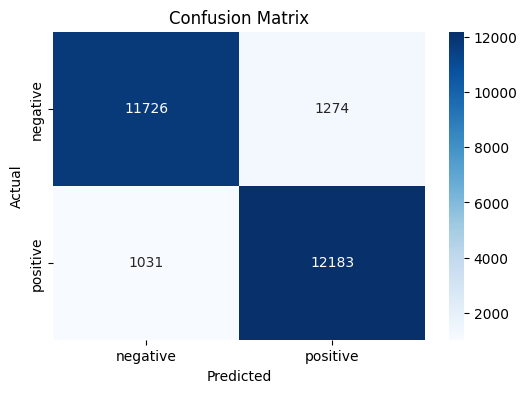

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


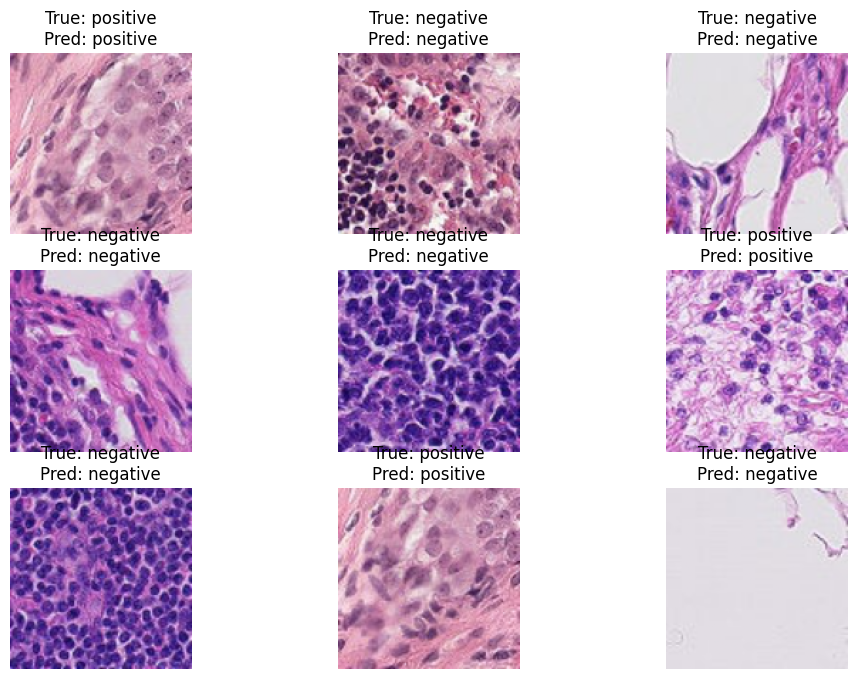

In [39]:
for images, labels in ds_test_processed.take(1):
    preds = tf.cast(vit_model.predict(images) > 0.5, tf.int32)
    
    plt.figure(figsize=(12, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        true_label = "positive" if labels[i] == 1 else "negative"
        pred_label = "positive" if preds[i] == 1 else "negative"
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")


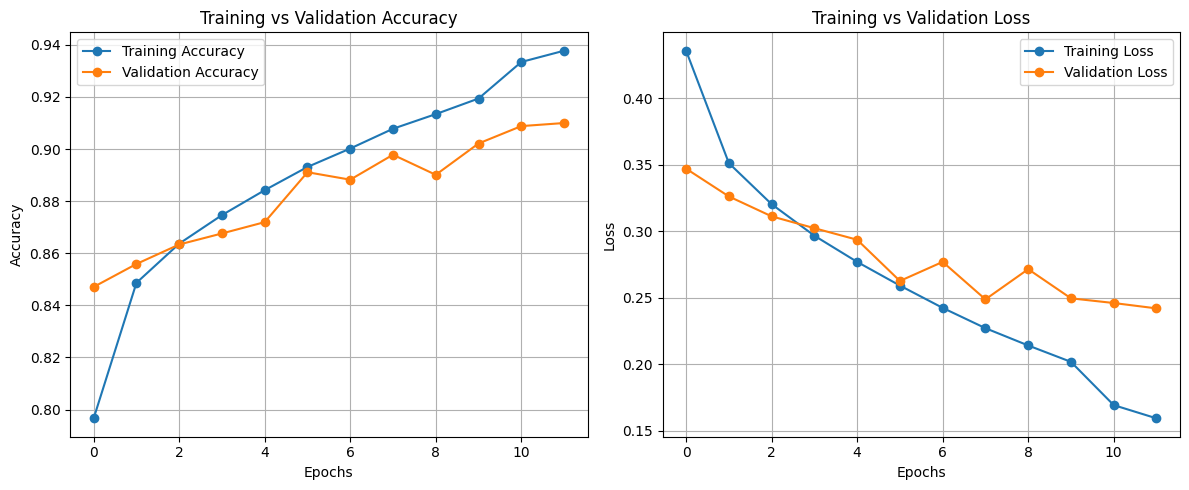

In [40]:
import matplotlib.pyplot as plt

# Extract values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,   
    decay_steps=10000,
    alpha=1e-5
)


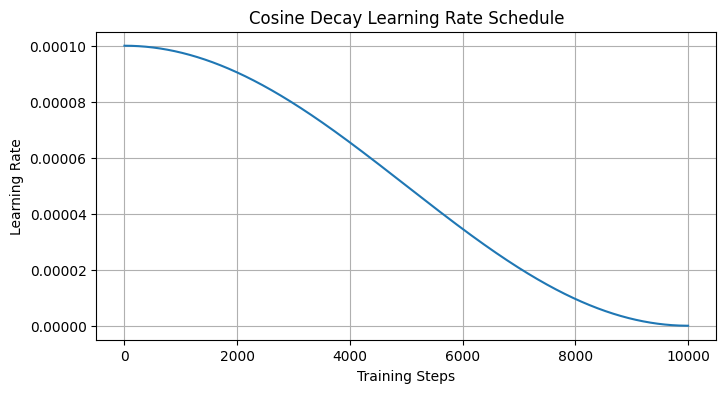

In [42]:
steps = tf.range(10000, dtype=tf.float32)
lrs = [lr_schedule(step).numpy() for step in steps]

plt.figure(figsize=(8, 4))
plt.plot(steps, lrs)
plt.title("Cosine Decay Learning Rate Schedule")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


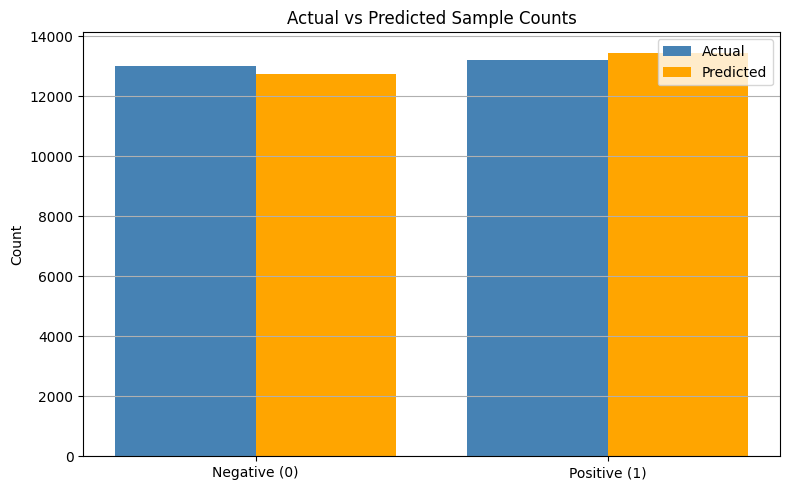

In [43]:
import matplotlib.pyplot as plt
import numpy as np


actual_counts = np.bincount(y_true)
predicted_counts = np.bincount(y_pred)


labels = ['Negative (0)', 'Positive (1)']
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
plt.bar(x - 0.2, actual_counts, width=0.4, label='Actual', color='steelblue')
plt.bar(x + 0.2, predicted_counts, width=0.4, label='Predicted', color='orange')
plt.xticks(x, labels)
plt.ylabel("Count")
plt.title("Actual vs Predicted Sample Counts")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
